In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import sklearn.svm as svm
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import itertools

In [2]:
### 导入数据
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv')
keys = np.array(df.columns)
dic = {}
for colname in df:
    arr = df.loc[:,colname].values
    dic[colname] = arr
dic[keys[-1]] = dic[keys[-1]] > 1400    # 将shares从数量值转化为布尔值

# 构建数据集与标签集
data_set = dic[keys[1]].reshape(-1,1)   # 数据集
for i in range(2,len(keys)-1):
    data_set = np.append(data_set, dic[keys[i]].reshape(-1,1), axis = 1)
label_set = dic[keys[-1]]               # 标签集

# 数据集划分         
x_train, x_test, y_train, y_test = train_test_split(data_set, label_set, test_size=0.3)     # 训练集与测试集按照7：3比例划分
xx_train, xx_val, yy_train, yy_val = train_test_split(x_train, y_train, test_size=0.2)      # 训练集中取五分之一作为验证集，与5折交叉验证比例相同

In [3]:
### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()     
x_train = scaler.fit_transform(x_train)     # 完整训练集
xx_train = scaler.fit_transform(xx_train)   # 除去验证集后的训练集
xx_val = scaler.fit_transform(xx_val)       # 验证集
x_test = scaler.fit_transform(x_test)       # 测试集

## 依据Fisher准则进行特征选择
# Fisher准则的基本原理：找到一个最合适的投影轴，使两类样本在该轴上投影之间的距离尽可能远，而每一类样本的投影尽可能紧凑，从而使分类效果为最佳。
J_fisher = []
feature_num = [5, 10, 20, 30, 50, xx_train.shape[1]]
Model = svm.SVC(kernel='rbf', C=1, gamma=0.01)

# 基于样本类别进行分类
idx_0 = np.argwhere(yy_train == False)
idx_1 = np.argwhere(yy_train == True)
X_train_0 = np.mat(xx_train[idx_0])
X_train_1 = np.mat(xx_train[idx_1])

# 基于类内类间距离的判据计算每个特征的投影距离
for i in range(xx_train.shape[1]):
    mu_0 = np.mean(X_train_0[:,i])
    mu_1 = np.mean(X_train_1[:,i])
    sigma_0 = np.var(X_train_0[:,i])
    sigma_1 = np.var(X_train_1[:,i])
    J = (mu_0 - mu_1)**2/(sigma_0**2 + sigma_1**2)
    J_fisher.append(J)

In [4]:
# 根据目标特征数k选择距离最远的前k个特征进行学习
for i in feature_num:
    feature_f = []
    J_f = np.argsort(J_fisher)
    feature_f = J_f[-i:]

    # 计算k个特征下的准确率
    X_train_fselected = xx_train[:,feature_f]
    X_test_fselected = xx_val[:,feature_f]
    Model.fit(X_train_fselected, yy_train)
    Y_pred_f_v = Model.predict(X_test_fselected)
    Y_pred_f_t = Model.predict(X_train_fselected)
    acc_f_v = accuracy_score(Y_pred_f_v, yy_val)
    acc_f_t = accuracy_score(Y_pred_f_t, yy_train)

    print(str(i),"features, train acc：", acc_f_t)
    print(str(i),"features, val acc：", acc_f_v)
    print(str(i),"features index",feature_f)

5 features, train acc： 0.6076683763558396
5 features, val acc： 0.6058516899276947
5 features index [13 37 17 40 26]
10 features, train acc： 0.6302446817455646
10 features, val acc： 0.6325878594249201
10 features index [42 24 16 35 15 13 37 17 40 26]
20 features, train acc： 0.6390734045236693
20 features, val acc： 0.6388094837733311
20 features index [38 43  8 48 11 25 44 39 36  6 42 24 16 35 15 13 37 17 40 26]
30 features, train acc： 0.6568990162280333
30 features, val acc： 0.6517571884984026
30 features index [32 58 18  1 56 27 28 29 41 45 38 43  8 48 11 25 44 39 36  6 42 24 16 35
 15 13 37 17 40 26]
50 features, train acc： 0.6801479862103759
50 features, val acc： 0.6633596771481419
50 features index [34  9 23 30 50 46 19 49 33 10 22 55 31  7 20 47 12  2 51  0 32 58 18  1
 56 27 28 29 41 45 38 43  8 48 11 25 44 39 36  6 42 24 16 35 15 13 37 17
 40 26]


In [5]:
# 依据验证结果选择特征
feature = J_f[-50:]
x_train = x_train[:,feature]
x_test = x_test[:,feature]

In [ ]:
### 模型训练与网格化参数搜索

#k折分层抽样
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=233)

#实例化svm模型
params = {'gamma': [0.001, 0.01, 0.1, 1, 10, 50], 'C': [1, 5, 10, 20, 50, 100]}
model = svm.SVC(kernel='rbf')
scores = ('accuracy', 'precision', 'f1', 'recall', 'roc_auc')   #取五个参数作为评价指标
gs = GridSearchCV(model, params, refit= 'accuracy', verbose= 1, cv= skf, scoring= scores)
gs.fit(x_train, y_train)
print('best params: ',gs.best_params_)
print('best score: ', gs.best_score_)

In [8]:
# 保存网格化搜索结果
np.save('./result/svm_cv_results_1209_36.npy', gs.cv_results_)  

In [ ]:
## 依次比较五项评价指标结果
res = gs.cv_results_
idx = {}

In [17]:
# 按顺序执行五个代码块后再逆序执行一遍，可以获得全部结果
key = 'test_accuracy'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
# 打印每项指标中效果最好的一组参数在当前指标中的结果
for k in idx:
    print(k, res["mean_" + key][idx[k]])        # 当前指标结果
    print(gs.cv_results_['params'][idx[k]])     # 对应参数

test_accuracy 0.6572160769157721
{'C': 5, 'gamma': 0.01}
test_precision 0.6572160769157721
{'C': 5, 'gamma': 0.01}
test_f1 0.6569805566391453
{'C': 1, 'gamma': 0.01}
test_recall 0.6427203839091931
{'C': 1, 'gamma': 0.1}
test_roc_auc 0.6569805566391453
{'C': 1, 'gamma': 0.01}


In [16]:
# 比较结果
key = 'test_precision'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6623537664022299
{'C': 5, 'gamma': 0.01}
test_precision 0.6623537664022299
{'C': 5, 'gamma': 0.01}
test_f1 0.6572126709918894
{'C': 1, 'gamma': 0.01}
test_recall 0.6341738278252453
{'C': 1, 'gamma': 0.1}
test_roc_auc 0.6572126709918894
{'C': 1, 'gamma': 0.01}


In [15]:
# 比较结果
key = 'test_f1'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6458361019745459
{'C': 5, 'gamma': 0.01}
test_precision 0.6458361019745459
{'C': 5, 'gamma': 0.01}
test_f1 0.6508159066127115
{'C': 1, 'gamma': 0.01}
test_recall 0.6472213341547649
{'C': 1, 'gamma': 0.1}
test_roc_auc 0.6508159066127115
{'C': 1, 'gamma': 0.01}


In [14]:
# 比较结果
key = 'test_recall'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6303399831025743
{'C': 5, 'gamma': 0.01}
test_precision 0.6303399831025743
{'C': 5, 'gamma': 0.01}
test_f1 0.6447841095229063
{'C': 1, 'gamma': 0.01}
test_recall 0.6608565040720498
{'C': 1, 'gamma': 0.1}
test_roc_auc 0.6447841095229063
{'C': 1, 'gamma': 0.01}


In [13]:
# 比较结果
key = 'test_roc_auc'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.7120896595580632
{'C': 5, 'gamma': 0.01}
test_precision 0.7120896595580632
{'C': 5, 'gamma': 0.01}
test_f1 0.7137472112719394
{'C': 1, 'gamma': 0.01}
test_recall 0.690440850503163
{'C': 1, 'gamma': 0.1}
test_roc_auc 0.7137472112719394
{'C': 1, 'gamma': 0.01}


In [19]:
# 绘制混淆矩阵（直接调用）
def plot_confusion_matrix(cm, labels_name, title):
    '''
    inputs:
    cm: confusion_matrix result
    labels_name: list, the label names draw on the plt
    title: plt name

    outputs:
    show the visualization confusion matrix
    '''
    plt.figure(figsize=(15,8),dpi=100)
    plt.subplot(1,2,1)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if int(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

    
    plt.subplot(1,2,2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
# 混淆矩阵绘制代码来源以下两篇博客：
# https://blog.csdn.net/kane7csdn/article/details/83756583
# https://blog.csdn.net/qq_18617009/article/details/103345308

In [18]:
### 模型预测
## {'svm__C': 1, 'svm__gamma': 0.01}
model1 = svm.SVC(kernel='rbf', C=1, gamma=0.01)
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)

In [20]:
## {'svm__C': 5, 'svm__gamma': 0.01}
model2 = svm.SVC(kernel='rbf', C=5, gamma=0.01)
model2.fit(x_train, y_train)
y_pred2 = model2.predict(x_test)

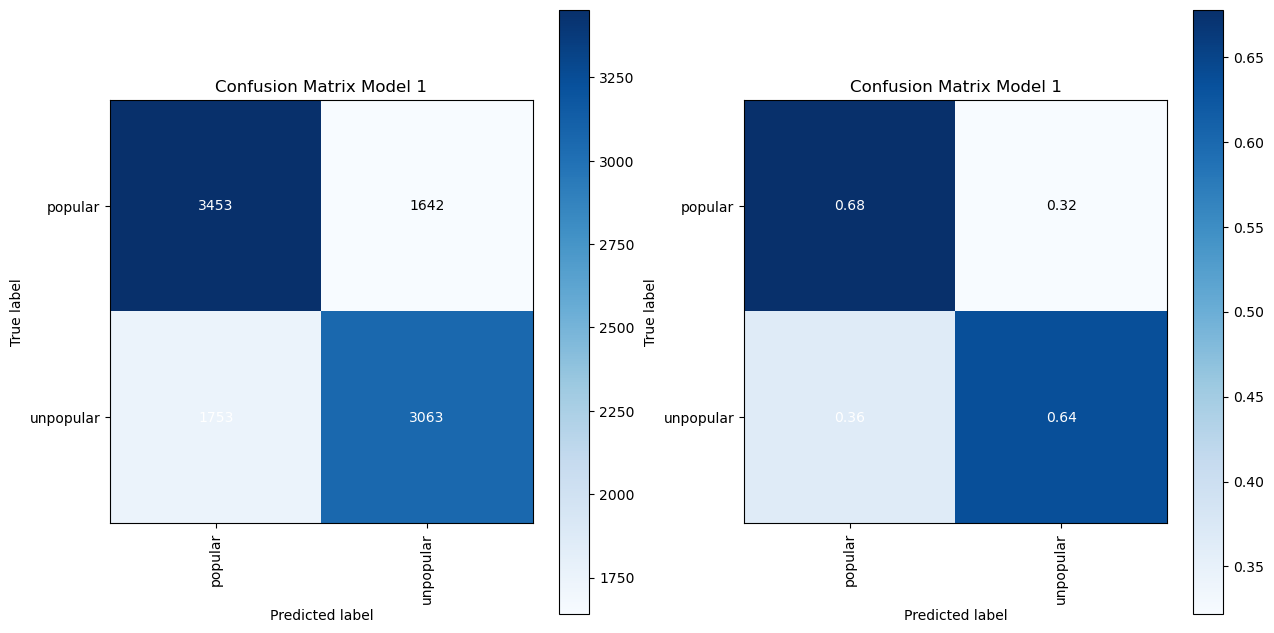

acc: 0.6574513167187973
pre: 0.651009564293305
recall: 0.6360049833887044
f1: 0.6434198088436089
AUCf1: 0.6568641207424386


In [21]:
## 绘制混淆矩阵
# {'svm__C': 1, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred1)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model 1")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred1)))
print("pre: " + str(precision_score(y_test, y_pred1)))
print("recall: " + str(recall_score(y_test, y_pred1)))
print("f1: " + str(f1_score(y_test, y_pred1)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred1)))

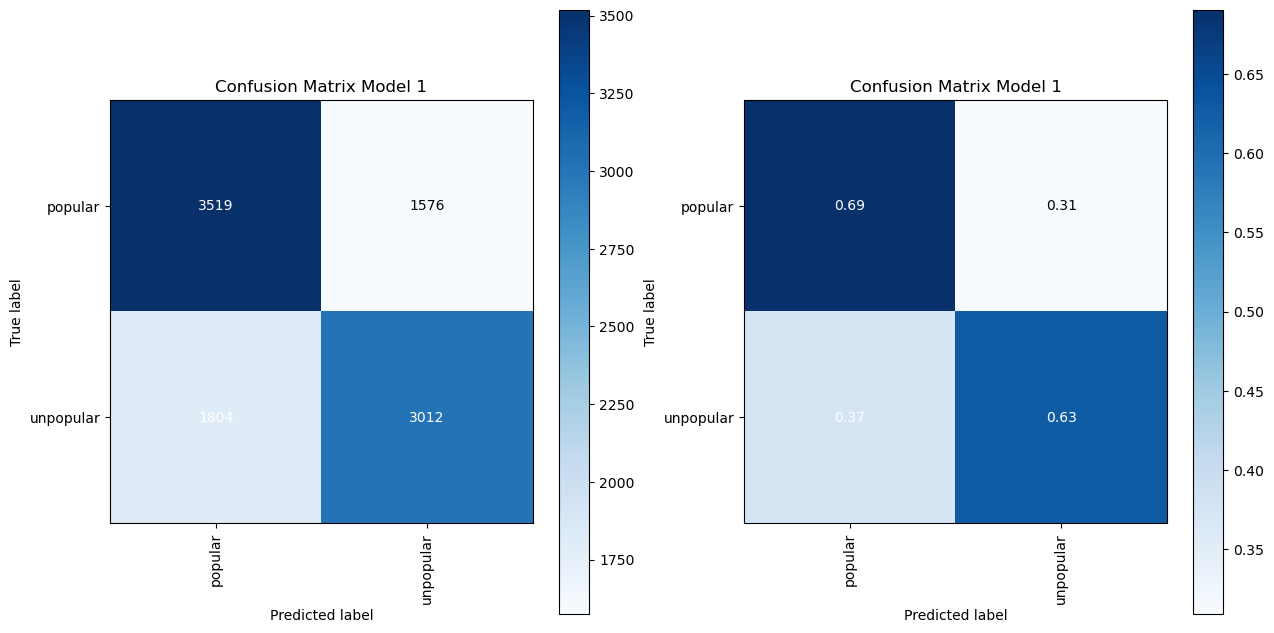

acc: 0.6589647866007466
pre: 0.6564952048823016
recall: 0.6254152823920266
f1: 0.6405784772437261
AUC: 0.6580462084187807


In [22]:
## 绘制混淆矩阵
# {'svm__C': 5, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred2)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model 1")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred2)))
print("pre: " + str(precision_score(y_test, y_pred2)))
print("recall: " + str(recall_score(y_test, y_pred2)))
print("f1: " + str(f1_score(y_test, y_pred2)))
print("AUC: " + str(roc_auc_score(y_test, y_pred2)))